In [559]:
# Import packages we'll need later on in this tutorial
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import math
import plotly.graph_objects as go
from collections import OrderedDict
from matplotlib.lines import Line2D  # Import for creating custom legend markers
import json
import copy
import random
import re
import seaborn as sns

# Import BW25 packages
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa
import brightway2 as bw 
from bw2calc import LeastSquaresLCA

In [560]:
from standards import *
from LCA_initialization import *

In [561]:
save_dir = results_folder('Results')

Folder name Results created


In [562]:
def LCA_initialization(name: str, db: str, flows: list) -> tuple:
    db_consq = 'Consequential'
    db_cyl = 'Cylinder'
    db_pellet = 'Pellet'
    bd.projects.set_current(name)

    bi.bw2setup()
    eidb = bd.Database(db)
    eidb_consq = bd.Database(db_consq)
    eidb_cyl = bd.Database(db_cyl)
    eidb_pellet = bd.Database(db_pellet)

    procces_keys = {key: None for key in flows}

    size = len(flows)
    all_acts = list(eidb) + list(eidb_consq) + list(eidb_cyl) + list(eidb_pellet)

    for act in all_acts:
        for proc in range(size):
            if act['name'] == flows[proc]:
                procces_keys[flows[proc]] = act['code']

    process = []
    key_counter = 0

    for key, item in procces_keys.items():
        try:
            if eidb.get(item) in eidb:
                process.append(eidb.get(item))
                print(f'Process "{key}" found in main database (eidb): {eidb.get(item)}')
            else:
                copied_process = copy_process(item, eidb_consq, eidb)
                if copied_process:
                    process.append(copied_process)
                    print('Process copied')
                else:
                    print(f"Process with key '{item}' not found in the consequential database (eidb_consq) either.")
        except KeyError:
            print(f"Process with key '{item}' not found in the database '{eidb}'")
            process = None
        key_counter += 1

    products_list = []
    
    if process:
        for proc in process:
            for exc in proc.exchanges():
                if exc['type'] == 'production':
                    products_list.append(exc.input)

    linked_processes_list = []

    if process:
        for proc in process:
            for exc in proc.exchanges():
                linked_processes_list.append(exc.input)

            linked_processes_list = list(set(linked_processes_list))

        proc_keys = {}
        name_keys = {}

        for linked_process in linked_processes_list:
            if linked_process[0] not in proc_keys:
                proc_keys[linked_process[0]] = []
                name_keys[linked_process[0]] = []
            proc_keys[linked_process[0]].append(linked_process[1])
            name_keys[linked_process[0]].append(linked_process)

    all_methods = [m for m in bw.methods if 'EF v3.1 EN15804' in str(m)]
    filtered_methods = [method for method in all_methods if "climate change:" not in method[1]]
    removed_methods = [method[1] for method in all_methods if "climate change:" in method[1]]

    impact_category = filtered_methods
    
    plot_x_axis = [0] * len(impact_category)
    for i in range(len(plot_x_axis)):
        plot_x_axis[i] = impact_category[i][1]

    product_details = {}
    product_details_code = {}

    if process:
        for proc in process:
            product_details[proc['name']] = []
            product_details_code[proc['name']] = []

            for exc in proc.exchanges():
                if 'Use' in exc.output['name'] and exc['type'] == 'biosphere':
                    product_details[proc['name']].append({exc.input['name']: [exc['amount'], exc.input]})
                    if exc.input in eidb or exc.input in eidb_consq or exc.input in eidb_cyl:
                        product_details_code[proc['name']].append([exc.output, exc.output['name'], exc.output['code'], exc['amount']])
                elif exc['type'] == 'technosphere':
                    product_details[proc['name']].append({exc.input['name']: [exc['amount'], exc.input]})
                    if exc.input in eidb or exc.input in eidb_consq or exc.input in eidb_cyl:
                        product_details_code[proc['name']].append([exc.input, exc.input['name'], exc.input['code'], exc['amount']])

    idx_df = []
    fu_val = []
    p_code = []

    for process_name, details in product_details.items():
        for detail in range(len(details)):
            for key, item in details[detail].items():
                idx_df.append(key)
                fu_val.append(details[detail][key][0])
                p_code.append(details[detail][key])

    FU_proc = []

    for flow in flows:
        for flow_length in range(len(product_details[flow])):
            for key in product_details[flow][flow_length].keys():
                if flow in key:
                    key = key.replace(f'{flow} ', '')
                FU_proc.append(key)

    FU = []
    for key, item in product_details.items():
        for idx in item:
            for n, m in idx.items():
                FU.append({key: {m[1]: m[0]}})

    print('Initialization is done')
    return FU, FU_proc, impact_category, plot_x_axis, product_details_code

def copy_process(process_code: str, eidb_consq, eidb):
    try:
        external_process = eidb_consq.get(process_code)
        if external_process:
            new_process = eidb.new_activity(
                code=external_process['code'],
                name=external_process['name'],
                unit=external_process['unit'],
                location=external_process['location'],
            )
            for exc in external_process.exchanges():
                new_process.new_exchange(
                    input=exc.input,
                    output=new_process,
                    type=exc['type'],
                    amount=exc['amount'],
                    unit=exc['unit']
                )
            new_process.save()
            print(f"Process '{external_process['name']}' copied from eidb_consq to eidb.")
            return new_process
    except Exception as e:
        print(f"Error copying process from eidb_consq: {e}")
    return None


In [570]:
def life_cycle_impact_assessment(flows, functional_unit, impact_categories, process):
    # Define the dimensions
    n = len(flows)  # number of rows (flows)
    m = len(impact_categories)  # number of columns (impact categories)

    # Create a DataFrame to store results
    df = pd.DataFrame(0, index=flows, columns=impact_categories, dtype=object)  # dtype=object to handle lists

    calc_count = 1
    row_counter = 0

    # Loop through impact categories
    for col, impact in enumerate(impact_categories):
        # Loop through flows
        for f in flows:
            df_lst = []  # Clear list for each flow in each impact category
            for func_unit in range(len(functional_unit)):
                for FU_key, FU_item in functional_unit[func_unit].items():
                    # cat = impact_categories[col]
                    if f in FU_key:
                        # Perform LCA
                        lca = bw.LCA(FU_item, impact)
                        lca.lci()
                        lca.lcia()
                        if len(process) == 1:
                            df_lst.append([process, lca.score])
                        else:
                            df_lst.append([process[func_unit], lca.score])

                        # Print progress
                        print(f"Calculation {calc_count} of {m * len(functional_unit)}", FU_item, impact[1], lca.score)
                        calc_count += 1
            
            # Assign the list of results to the DataFrame
            df.iloc[row_counter, col] = df_lst
            # Update the row counter
            row_counter += 1
            
            print(f'{impact[1]} at row {row_counter - 1} col {col} has been assigned the list {df_lst}')

            
            if row_counter == len(flows):  # Reset when all flows have been processed
                row_counter = 0

    return df


In [564]:
def life_cycle_impact_assessment_contribution(flows, functional_unit, impact_categories, process):
    # Define the dimensions
    n = len(flows)  # number of rows (flows)
    m = len(impact_categories)  # number of columns (impact categories)

    # Create a DataFrame to store results
    df = pd.DataFrame(0, index=flows, columns=impact_categories, dtype=object)  # dtype=object to handle lists

    calc_count = 1
    row_counter = 0

    # Loop through impact categories
    for impact in range(m):
        # Loop through flows
        for f in flows:
            df_lst = []  # Clear list for each flow in each impact category
            for func_unit in range(len(functional_unit)):
                for FU_key, FU_item in functional_unit[func_unit].items():
                    cat = impact_categories[impact]
                    if f in FU_key:
                        # Perform LCA
                        lca = bw.LCA(FU_item, cat)
                        lca.lci()
                        lca.lcia()
                        if len(process) == 1:
                            df_lst.append([process, lca.score])
                        else:
                            df_lst.append([process[func_unit], lca.score])

                        # Print progress
                        print(f"Calculation {calc_count} of {m * len(functional_unit)}", FU_item, cat[1], lca.score)
                        calc_count += 1
            
            # Assign the list of results to the DataFrame
            df.iloc[row_counter, impact] = df_lst
            print(f'{cat[1]} at row {row_counter} col {impact} has been assigned the list {df_lst}')

        # Update the row counter
        row_counter += 1
        if row_counter == len(flows):  # Reset when all flows have been processed
            row_counter = 0

    return df


In [565]:
# Your name variable should be the name of the project.
name = "RA - Rune"
db = 'DU consequential final'

flows = ['sc1 - No DU', 'sc2 - CDU', 'sc3 - MDU']
flow_legend = ['No DU', 'CDU', 'MDU']

FU, FU_proc, impact_category, plot_x_axis, sub_product_details = LCA_initialization(name, db, flows)


Biosphere database already present!!! No setup is needed
Process "sc1 - No DU" found in main database (eidb): 'sc1 - No DU' (unit, GLO, None)
Process "sc2 - CDU" found in main database (eidb): 'sc2 - CDU' (unit, GLO, None)
Process "sc3 - MDU" found in main database (eidb): 'sc3 - MDU' (unit, GLO, None)
Initialization is done


In [571]:
df = life_cycle_impact_assessment(flows, FU, impact_category, FU_proc)
df

Calculation 1 of 256 {'Steel cylinder' (unit, GLO, None): 6.84931506849315e-06} acidification 2.4821260976820004e-05
Calculation 2 of 256 {'nitrous oxide production' (kilogram, RER, None): 0.867460675121784} acidification 0.010968005818038482
Calculation 3 of 256 {'Use phase basecase' (unit, GLO, None): 1} acidification 0.0
Calculation 4 of 256 {'EoL 50L cylinder - FU' (unit, GLO, None): 6.84931506849315e-06} acidification 0.0015934554481004321
acidification at row 0 col 0 has been assigned the list [['Steel cylinder', 2.4821260976820004e-05], ['nitrous oxide production', 0.010968005818038482], ['Use phase basecase', 0.0], ['EoL 50L cylinder - FU', 0.0015934554481004321]]
Calculation 5 of 256 {'CDU updated' (unit, GLO, None): 6.84931506849315e-06} acidification 0.033699763481384294
Calculation 6 of 256 {'Steel cylinder' (unit, GLO, None): 6.84931506849315e-06} acidification 2.4821260976820004e-05
Calculation 7 of 256 {'nitrous oxide production' (kilogram, RER, None): 0.867460675121784}

KeyboardInterrupt: 

In [572]:
file_name = r'Results\Ananas - CONSQ.xlsx'
sheet_name = 'Ananas'

In [573]:
# Convert each cell to a JSON string for all columns
df_save = df.applymap(lambda x: json.dumps(x) if isinstance(x, list) else x)

# Save to Excel
with pd.ExcelWriter(file_name) as writer:
    df_save.to_excel(writer, sheet_name=sheet_name, index=False, header=True)

print('DataFrame with nested lists written to Excel successfully.')

DataFrame with nested lists written to Excel successfully.


C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\1716332511.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_save = df.applymap(lambda x: json.dumps(x) if isinstance(x, list) else x)


In [574]:
with open("impact_categories", "w") as fp:
    json.dump(impact_category, fp)

In [575]:
filtered_dict = {}
for scenario in FU:
    for sc_key, sc_item in scenario.items():

        for sc_proc_key, sc_proc_item in sc_item.items():
            if 'Consequential' in sc_proc_key[0]:
                filtered_dict[sc_proc_key] = sc_proc_item 
                print(sc_item)
filtered_dict

{'nitrous oxide production' (kilogram, RER, None): 0.867460675121784}
{'nitrous oxide production' (kilogram, RER, None): 0.867460675121784}
{'nitrous oxide production' (kilogram, RER, None): 0.867460675121784}


{'nitrous oxide production' (kilogram, RER, None): 0.867460675121784}

In [576]:
sub_proccess = {}
amount = {}
for key, details in sub_product_details.items():
    print(f"Process: {key}")

    sub_proccess[key] = []

    for detail in details:
        
        sub_proccess[key].append([detail[0], detail[1], detail[3]])
        amount[detail[1]] = []
        amount[detail[1]].append(detail[3])


Process: sc1 - No DU
Process: sc2 - CDU
Process: sc3 - MDU


In [577]:
# Initializing empty dictionaries to store the results
FU_sub = {key: [] for key in sub_proccess}
FU_sub_proc = {key: [] for key in sub_proccess}


for proc, sub_proc in sub_proccess.items():
    # print(f'Process: {proc}')
    temp = {}
    fu_temp = []
    for proc_idx in range(len(sub_proc)):
        #print(sub_proc[proc_idx])
        flow = [sub_proc[proc_idx][1]]
        
        db_proc = sub_proc[proc_idx][0][0]
        #print(f'Flow : {flow}, Database: {db_proc}, Subprocess : {sub_proc}')
        if db_proc == 'Consequential' and sub_proc[proc_idx][0] in filtered_dict:
            #print(flow)
            fu = [{flow[0] : filtered_dict}]
            p = flow

        else:
            fu, p, ic, pxa, kokos = LCA_initialization(name, db_proc,flow)

        
        temp[flow[0]] = []
        temp[flow[0]].append(p)
        for fuck in fu:
            fu_temp.append(fuck)

    FU_sub[proc].append(fu_temp)
    FU_sub_proc[proc].append(temp)
    


Biosphere database already present!!! No setup is needed
Process "Steel cylinder" found in main database (eidb): 'Steel cylinder' (unit, GLO, None)
Initialization is done
Biosphere database already present!!! No setup is needed
Process "Use phase basecase" found in main database (eidb): 'Use phase basecase' (unit, GLO, None)
Initialization is done
Biosphere database already present!!! No setup is needed
Process "EoL 50L cylinder - FU" found in main database (eidb): 'EoL 50L cylinder - FU' (unit, GLO, None)
Initialization is done
Biosphere database already present!!! No setup is needed
Process "CDU updated" found in main database (eidb): 'CDU updated' (unit, GLO, None)
Initialization is done
Biosphere database already present!!! No setup is needed
Process "Steel cylinder" found in main database (eidb): 'Steel cylinder' (unit, GLO, None)
Initialization is done
Biosphere database already present!!! No setup is needed
Process "Use phase CDU" found in main database (eidb): 'Use phase CDU' (

In [578]:
df_sub = {} # life_cycle_impact_assessment(sub_proccess, FU_sub, impact_category, FU_sub_proc)
proc_counter = 1
flow_sub = []
functional_unit_sub = []
for key, item in FU_sub_proc.items():
    # print(key)
    df_temp = {}
    for pommesfrit in item:
        for pom_process, pom_subprocess in pommesfrit.items():
            for pompom in pom_subprocess:

                fu_proc_temp = pom_process
                fu_sub_proc_temp = pompom
                fu_temp = FU_sub[key][0]

                proc_counter += 1
                flow_sub.append(fu_proc_temp)
        functional_unit_sub.append(fu_temp)


In [579]:
idx = []
sc_counter = 1
for k, i in FU_sub_proc.items():
    for kk, ii in i[0].items():
        idx.append(kk + f' - sc {sc_counter}')
    sc_counter += 1


In [580]:
with open("index_rune", "w") as fp:
    json.dump(idx, fp)

In [581]:
n = len(idx) #len(proc_counter)  # number of rows (flows)
m = len(impact_category)  # number of columns (impact categories)



df_cont = pd.DataFrame(0, index=idx, columns=impact_category, dtype=object)  # dtype=object to handle lists


In [582]:
def N2O_use_replace(FU, FU_sub):
    functional_unit_sub_new = copy.deepcopy(FU_sub)

    for fcu in range(len(FU_sub)):
        for fu_ind in range(len(FU_sub[fcu])):
            for fu_ind_key, fu_ind_item in FU_sub[fcu][fu_ind].items():
                funky_key = [i for i in fu_ind_item.keys()][0]
                for fu_sc in range(len(FU)):
                    for uuuu, fu_sc_val in FU[fu_sc].items():
                        funky_key_sc = [i for i in fu_sc_val.keys()][0]
                        if fu_ind_key in f'{funky_key_sc}' and 'biosphere3' in funky_key[0]:
                            functional_unit_sub_new[fcu][fu_ind].update({fu_ind_key : fu_sc_val})
    return functional_unit_sub_new


In [583]:
functional_unit_sub_new = N2O_use_replace(FU, functional_unit_sub)


In [584]:
flow_count = 0

for func_unit in functional_unit_sub:
    flow_count += len(func_unit) 



In [517]:
calc = m*flow_count
dct = {}
row_counter = 0
calc_count = 1


# Iterate over impact categories (columns)
for column in range(m):
    # Iterate over processes and their corresponding flows in FU_sub_proc
    cat = impact_category[column]
    for k, i in FU_sub_proc.items():
        # For each flow in the current process
        
        for f in i[0].keys():
            accounted_flows = []
            
            print(f"Processing flow: {f} in impact category: {cat[1]}")

            # Initialize the result list for the current flow
            dct[f] = []
            df_lst = []

            # Perform LCA for each functional unit
            for func_unit in range(len(functional_unit_sub_new)):
                
                for FU_dict in functional_unit_sub_new[func_unit]:
                    for  dk, di in FU_dict.items():
                        # print(dk, di)
                        div = [proc_val for proc_val in di.values()][0]
                        if dk in f and di.keys() not in accounted_flows:
                            
                            accounted_flows.append(di.keys())
                            FU_dict_copy = copy.deepcopy(FU_dict)

                            # Update the flow amounts
                            for key, item in FU_dict.items():
                                for FU_key, FU_val in item.items():
                                    FU_dict_copy[key][FU_key] = FU_dict[key][FU_key] * amount[f][0]
                
                            # Perform LCA
                            lca = bw.LCA(FU_dict_copy[key], cat)
                            lca.lci()
                            lca.lcia()

                            # Append the result (using the temp variable for functional unit sub-process)
                            df_lst.append([f'{FU_key}', lca.score])
                            print(f"{FU_key} Calculation {calc_count} of {calc}, Score: {lca.score} {cat[1]}")
                            calc_count += 1

            
            

            # # Assign the result list to the DataFrame for the current flow and column (impact category)
            df_cont.iloc[row_counter, column] = df_lst
            print(f'row : {row_counter}, col : {column} is assigned list : {df_lst}')


            # Update the row counter after processing all flows in the current impact category
            row_counter += 1

            # Reset the row counter if it reaches the number of rows (flows)
            if row_counter == n:
                row_counter = 0


Processing flow: Steel cylinder in impact category: acidification
'Compresser opration 50L' (unit, GLO, None) Calculation 1 of 1264, Score: 1.1176280771220774e-07 acidification
'Steel cylinder prod.' (unit, GLO, None) Calculation 2 of 1264, Score: 2.277291346205234e-05 acidification
'Hydrastic testing 50L' (unit, GLO, None) Calculation 3 of 1264, Score: 1.5561269172951786e-06 acidification
'transport, freight, lorry 16-32 metric ton, EURO6' (ton kilometer, RER, None) Calculation 4 of 1264, Score: 3.434578940649671e-07 acidification
'transport, freight, inland waterways, barge tanker' (ton kilometer, RER, None) Calculation 5 of 1264, Score: 3.699990455344564e-08 acidification
row : 0, col : 0 is assigned list : [["'Compresser opration 50L' (unit, GLO, None)", 1.1176280771220774e-07], ["'Steel cylinder prod.' (unit, GLO, None)", 2.277291346205234e-05], ["'Hydrastic testing 50L' (unit, GLO, None)", 1.5561269172951786e-06], ["'transport, freight, lorry 16-32 metric ton, EURO6' (ton kilomet

In [585]:
file_name_sub = r'Results\Ananas sub - CONSQ.xlsx'


In [586]:
# Convert each cell to a JSON string for all columns
df_sub = df_cont.applymap(lambda x: json.dumps(x) if isinstance(x, list) else x)

# Save to Excel
with pd.ExcelWriter(file_name_sub) as writer:
    df_sub.to_excel(writer, sheet_name=sheet_name, index=False, header=True)

print('DataFrame with nested lists written to Excel successfully.')

DataFrame with nested lists written to Excel successfully.


C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\1256394485.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sub = df_cont.applymap(lambda x: json.dumps(x) if isinstance(x, list) else x)


In [587]:
df1_sub = pd.read_excel(file_name_sub)


In [588]:
# Reading from Excel
df1 = pd.read_excel(file_name)
df1_sub = pd.read_excel(file_name_sub)

# Convert JSON strings back to lists for all columns
df1 = df1.applymap(lambda x: json.loads(x) if isinstance(x, str) and x.startswith('[') else x)

df1 = df1.set_axis(flows)
df1.columns = impact_category

df_updated = df1.copy()
df_tot = df_updated.copy()


C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\3133344276.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = df1.applymap(lambda x: json.loads(x) if isinstance(x, str) and x.startswith('[') else x)


In [589]:
df_updated

,"(EF v3.1 EN15804, acidification, accumulated exceedance (AE))","(EF v3.1 EN15804, climate change, global warming potential (GWP100))","(EF v3.1 EN15804, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe))","(EF v3.1 EN15804, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels)","(EF v3.1 EN15804, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P))","(EF v3.1 EN15804, eutrophication: marine, fraction of nutrients reaching marine end compartment (N))","(EF v3.1 EN15804, eutrophication: terrestrial, accumulated exceedance (AE))","(EF v3.1 EN15804, human toxicity: carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, ionising radiation: human health, human exposure efficiency relative to u235)","(EF v3.1 EN15804, land use, soil quality index)","(EF v3.1 EN15804, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves))","(EF v3.1 EN15804, ozone depletion, ozone depletion potential (ODP))","(EF v3.1 EN15804, particulate matter formation, impact on human health)","(EF v3.1 EN15804, photochemical oxidant formation: human health, tropospheric ozone concentration increase)","(EF v3.1 EN15804, water use, user deprivation potential (deprivation-weighted water consumption))"
sc1 - No DU,"[[Steel cylinder, 2.4821260976820004e-05], [ni...","[[Steel cylinder, 0.005456229514756893], [nitr...","[[Steel cylinder, 0.02689681145503979], [nitro...","[[Steel cylinder, 0.06471586600422786], [nitro...","[[Steel cylinder, 4.164145755153704e-06], [nit...","[[Steel cylinder, 5.439366377934605e-06], [nit...","[[Steel cylinder, 5.1440088432858044e-05], [ni...","[[Steel cylinder, 8.120702205798173e-11], [nit...","[[Steel cylinder, 6.725000501277105e-11], [nit...","[[Steel cylinder, 3.451402200181894e-05], [nit...","[[Steel cylinder, 0.05341058184255911], [nitro...","[[Steel cylinder, -6.260798244751308e-08], [ni...","[[Steel cylinder, 1.232676817653973e-10], [nit...","[[Steel cylinder, 5.476745429210785e-10], [nit...","[[Steel cylinder, 2.334134230290092e-05], [nit...","[[Steel cylinder, 0.0015157174317935512], [nit..."
sc2 - CDU,"[[CDU updated, 0.033699763481384294], [Steel c...","[[CDU updated, 0.12819826622266475], [Steel cy...","[[CDU updated, 1.4755335896694415], [Steel cyl...","[[CDU updated, 2.094289083153275], [Steel cyli...","[[CDU updated, 0.00010946578693302614], [Steel...","[[CDU updated, 0.00012323944886451918], [Steel...","[[CDU updated, 0.001291805268237013], [Steel c...","[[CDU updated, 3.23120762737068e-10], [Steel c...","[[CDU updated, 4.527936227184927e-09], [Steel ...","[[CDU updated, 0.022953633802310615], [Steel c...","[[CDU updated, 1.4453593855555278], [Steel cyl...","[[CDU updated, 2.3204757355396628e-05], [Steel...","[[CDU updated, 6.412188285949878e-09], [Steel ...","[[CDU updated, 2.9190976038666193e-08], [Steel...","[[CDU updated, 0.002678400846522548], [Steel c...","[[CDU updated, 0.04610221142028905], [Steel cy..."
sc3 - MDU,"[[MDU updated, 0.06909101812686011], [Steel cy...","[[MDU updated, 0.3591249304907266], [Steel cyl...","[[MDU updated, 5.562379935751366], [Steel cyli...","[[MDU updated, 5.548337101274091], [Steel cyli...","[[MDU updated, 0.0003663742164005576], [Steel ...","[[MDU updated, 0.000361856412791819], [Steel c...","[[MDU updated, 0.0037610866718165645], [Steel ...","[[MDU updated, 1.0716849152239044e-09], [Steel...","[[MDU updated, 1.1984131035265172e-08], [Steel...","[[MDU updated, 0.05186765582765432], [Steel cy...","[[MDU updated, 3.6900959224740673], [Steel cyl...","[[MDU updated, 7.762141348560289e-05], [Steel ...","[[MDU updated, 1.8962760185311458e-08], [Steel...","[[MDU updated, 6.342169280380604e-08], [Steel ...","[[MDU updated, 0.005810953630291378], [Steel c...","[[MDU updated, 0.1236924037638626], [Steel cyl..."


In [590]:
df_tot = df_updated.copy()

for col in range(df_updated.shape[1]):  # Iterate over columns
    for row in range(df_updated.shape[0]):  # Iterate over rows
        tot = 0
        for i in range(len(df_updated.iloc[row,col])):
            #print(df_updated.iloc[row,col][i][1])
            tot += df_updated.iloc[row,col][i][1]
        df_tot.iloc[row,col] = tot
        # print('New row')
df_tot

,"(EF v3.1 EN15804, acidification, accumulated exceedance (AE))","(EF v3.1 EN15804, climate change, global warming potential (GWP100))","(EF v3.1 EN15804, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe))","(EF v3.1 EN15804, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels)","(EF v3.1 EN15804, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P))","(EF v3.1 EN15804, eutrophication: marine, fraction of nutrients reaching marine end compartment (N))","(EF v3.1 EN15804, eutrophication: terrestrial, accumulated exceedance (AE))","(EF v3.1 EN15804, human toxicity: carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, ionising radiation: human health, human exposure efficiency relative to u235)","(EF v3.1 EN15804, land use, soil quality index)","(EF v3.1 EN15804, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves))","(EF v3.1 EN15804, ozone depletion, ozone depletion potential (ODP))","(EF v3.1 EN15804, particulate matter formation, impact on human health)","(EF v3.1 EN15804, photochemical oxidant formation: human health, tropospheric ozone concentration increase)","(EF v3.1 EN15804, water use, user deprivation potential (deprivation-weighted water consumption))"
sc1 - No DU,0.012586,231.50288,18.259086,53.328515,0.001044,0.00589,0.034156,0.0,0.0,0.477163,33.399506,0.00004,0.0,0.0,0.00835,4.901957
sc2 - CDU,0.04871,47.73204,20.471195,56.094419,0.001181,0.006286,0.039707,0.0,0.0,0.500575,64.879473,0.000074,0.0,0.0,0.011944,4.975535
sc3 - MDU,0.089185,47.915144,23.996928,59.094731,0.001412,0.006309,0.038841,0.0,0.0,0.529682,48.118258,0.000121,0.0,0.0,0.014764,5.040227


In [591]:
df_cols = df_tot.columns
df_cols = df_cols.to_list()

df_norm = pd.DataFrame().reindex_like(df_tot) #https://stackoverflow.com/questions/23195250/create-empty-dataframe-with-same-dimensions-as-another
for i in df_cols:
    scaling_factor = max(abs(df_tot[i]))
    # print(df_tot[i])
    for j in range(len(df_tot[df_cols[0]])):
        df_norm[i][j] =df_tot[i][j]/scaling_factor

# Selecting the columns from 1th column onwards
columns_to_plot = df_norm.columns


C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\3962810081.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_norm[i][j] =df_tot[i][j]/scaling_factor
C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\3962810081.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assig

In [592]:
index_list = list(df1.index.values)
plot_x_axis = [0] * len(impact_category)
for i in range(len(plot_x_axis)):
    if "photochemical oxidant formation" in impact_category[i][1]:
        plot_x_axis[i] = "photochemical oxidant formation"
    else:
        plot_x_axis[i] = impact_category[i][1].title()

df_GWP = df_updated[df_updated.columns[1]].to_frame()

In [593]:
x_axis = []
GWP_value = []

for df_size in range(len(df_GWP)):
    lst_x = []
    lst_GWP = []
    gwp_tot = 0
    for key in df_GWP.keys():
        for lst_size in range(len(df_GWP[key][df_size])):
            x = df_GWP[key][df_size][lst_size][0]
            gwp = df_GWP[key][df_size][lst_size][1]
            
            if '- FU' in x:
                #print(key)
                x = x.replace(f' - FU', '')
            if 'Use' in x:           
                x = 'Labor'
            if 'nitrous' in x:
                x = 'N2O prod.'
            if 'market for electricity' in x:
                x = 'Avoided electricity'
            if 'Steel' in x:
                x = 'Cylinder prod.'

            if '50L' in x:
                x = x.replace(' 50L', '')
            if 'updated' in x:
                x = x.replace('updated', 'prod.')

            lst_x.append(x)
            lst_GWP.append(gwp)
            gwp_tot += gwp
    
    lst_GWP.append(gwp_tot)
    lst_x.append('Total')
    x_axis.append(lst_x)
    GWP_value.append(lst_GWP)

# x_axis

C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\1795852045.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for lst_size in range(len(df_GWP[key][df_size])):
C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\1795852045.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df_GWP[key][df_size][lst_size][0]
C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\1795852045.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gwp = d

In [594]:
# Categories definitions
categories = ["Raw mat. + prod.", "Use", "EoL", "Total"]
category_mapping = {
    "Raw mat. + prod.": ["Cylinder prod.", "N2O prod.", "CDU prod.", "MDU prod.", "Production"],
    "Use": ["Labor"],
    "EoL": ["EoL cylinder", "EoL CDU", "EoL MDU"],
    "Total": ["Total"]
}

# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                if x_axis[x_lst][x] in item:
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            #print(val)
            plot_legend[key].append(val)


colors = plot_colors(temp,'turbo')


In [595]:
columns_to_plot = df_norm.columns

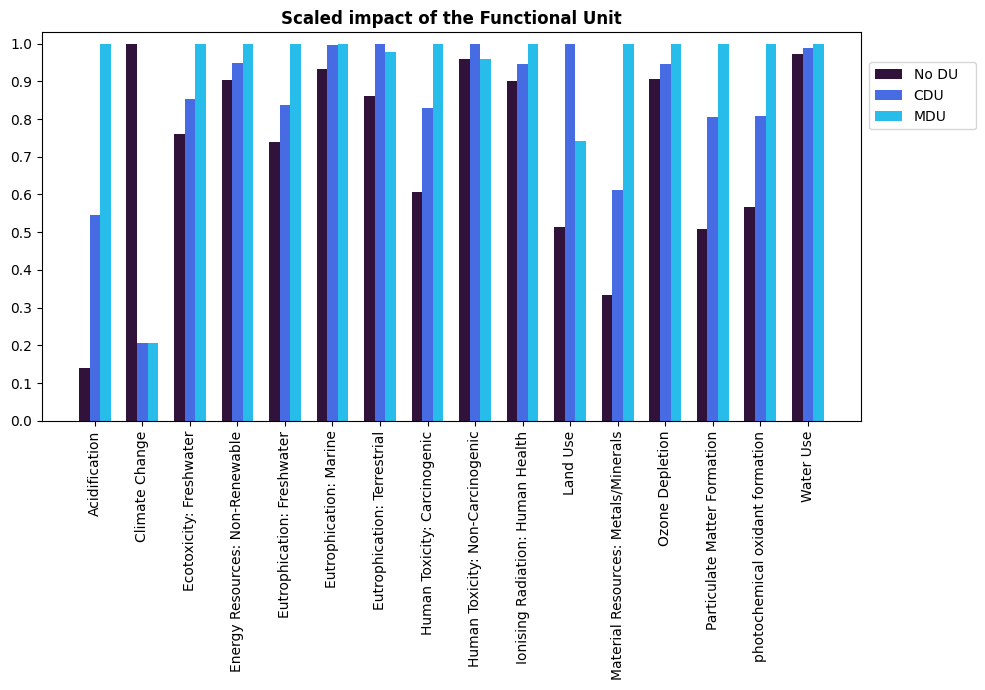

In [596]:

# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_norm)
bar_width = 1/(len(index_list) + 1.5) 
index = np.arange(len(columns_to_plot))

# Plotting each group of bars
for i, process in enumerate(df_norm.index):
    values = df_norm.loc[process, columns_to_plot].values
    ax.bar((index + i * bar_width), values, bar_width, label=process, color=colors[i])
    

# Setting labels and title
ax.set_title('Scaled impact of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(plot_x_axis)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

ax.legend(flow_legend,bbox_to_anchor=(1.01, .75, .13, 0), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=1)
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

In [597]:
directory = 'C:\\Users\\ruw\\Desktop\\RA\\'


# data_NW = pd.read_excel(file)


In [598]:
def LCA_normalization(directory, df):
    file = f'{directory}Single-use-vs-multi-use-in-health-care\\Norm + Weigh.xlsx'
    data_NW = pd.read_excel(file)
    columns = df.columns

    norm_lst = data_NW['Normalization']
    weigh_lst = data_NW['Weighting'].to_list

    norm_lst = [0]*(len(data_NW['Normalization']))
    weigh_lst = [0]*(len(data_NW['Weighting']))

    for i in range(len(data_NW['Normalization'])):
        norm_lst[i] = data_NW['Normalization'][i]
        weigh_lst[i] = data_NW['Weighting'][i]

    norm_df = pd.DataFrame().reindex_like(df) #https://stackoverflow.com/questions/23195250/create-empty-dataframe-with-same-dimensions-as-another
    weigh_df = pd.DataFrame().reindex_like(df)

    counter = 0
    for i in columns:
        for j in range(len(df[columns[0]])):
            norm_df[i][j] =df[i][j] * norm_lst[counter]
            weigh_df[i][j] =norm_df[i][j] * weigh_lst[counter]
        counter +=1

    lst = [0] * len(weigh_df[columns[0]])
    for j in range(len(weigh_df[columns[0]])):
        for i in columns:
            lst[j] += weigh_df[i][j]

    lst_norm_weighted = [0] * len(lst)
    lst_max = max(lst)


    for n in range(len(lst)):
        lst_norm_weighted[n] = lst[n]/lst_max

    return lst_norm_weighted

In [599]:
lst_scaled = LCA_normalization(directory, df_tot)

C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\2809958199.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  norm_df[i][j] =df[i][j] * norm_lst[counter]
C:\Users\ruw\AppData\Local\Temp\5\ipykernel_11316\2809958199.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the as

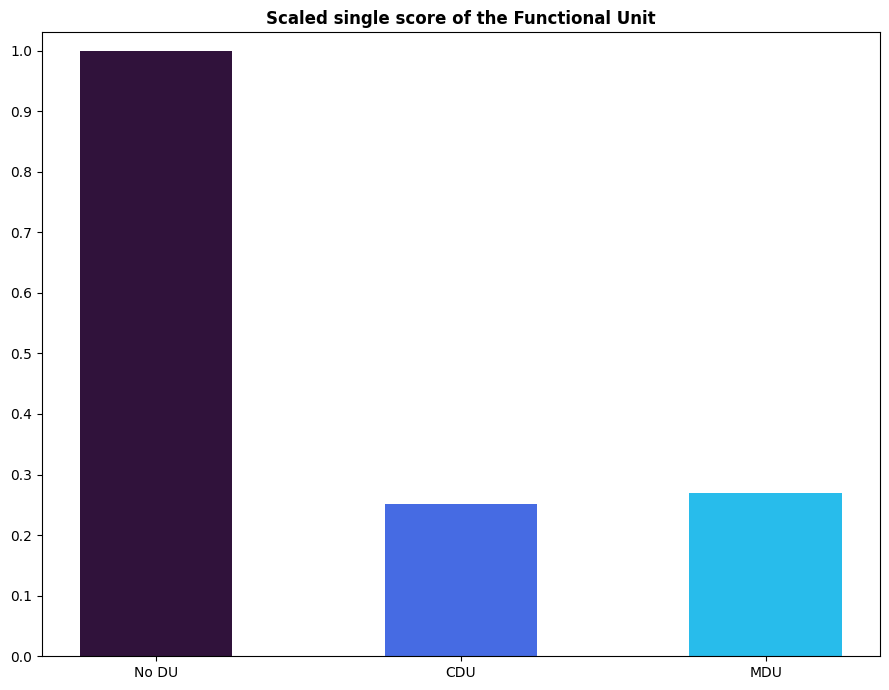

In [600]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_norm)
bar_width = 1/(len(index_list)-1) 
index = np.arange(len(index_list))   

ax.bar(index + bar_width, lst_scaled, bar_width, label=index_list, color=colors)

# Setting labels and title
ax.set_title('Scaled single score of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(flow_legend)
#plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

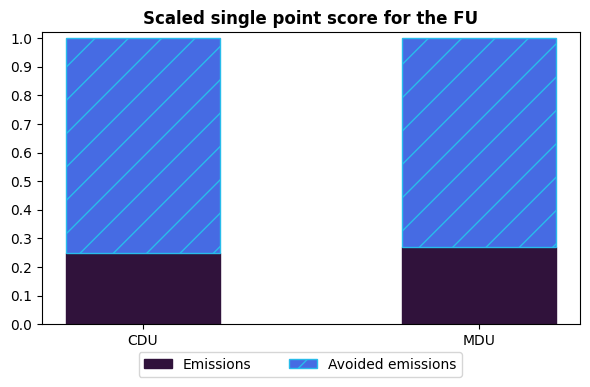

In [601]:
# Calculate bottom and top parts
bottoms = lst_scaled[1:]
last_value = lst_scaled[0]
tops = [last_value - bottom for bottom in bottoms]

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Bar positions
bar_positions = [0, 1.75]

# Bottom parts (first two values)
ax.bar(bar_positions, bottoms, label='Emissions',color=colors[0], edgecolor=colors[0])

# Top parts (values after subtraction) with hatching
ax.bar(bar_positions, tops, bottom=bottoms, label='Avoided emissions', color=colors[1], edgecolor=colors[2], hatch='/')


# Adding labels and titlecolors[1]
ax.set_xticks(bar_positions)
ax.set_xticklabels(['CDU', 'MDU'])

# Setting labels and title
ax.set_title('Scaled single point score for the FU',weight='bold')
plt.yticks(np.arange(0, 1.02, step=0.1))
plt.ylim(0, 1.02)

ax.legend(['Emissions', 'Avoided emissions'], bbox_to_anchor=(0.18, -0.18, 0.6, 0.2), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=2)

# ax.plot(bottoms,'o',color=colors[1])
# Show the plot
plt.tight_layout()
#plt.savefig(os.path.join(save_dir, 'GWP_res.jpg'), bbox_inches='tight')
plt.show()

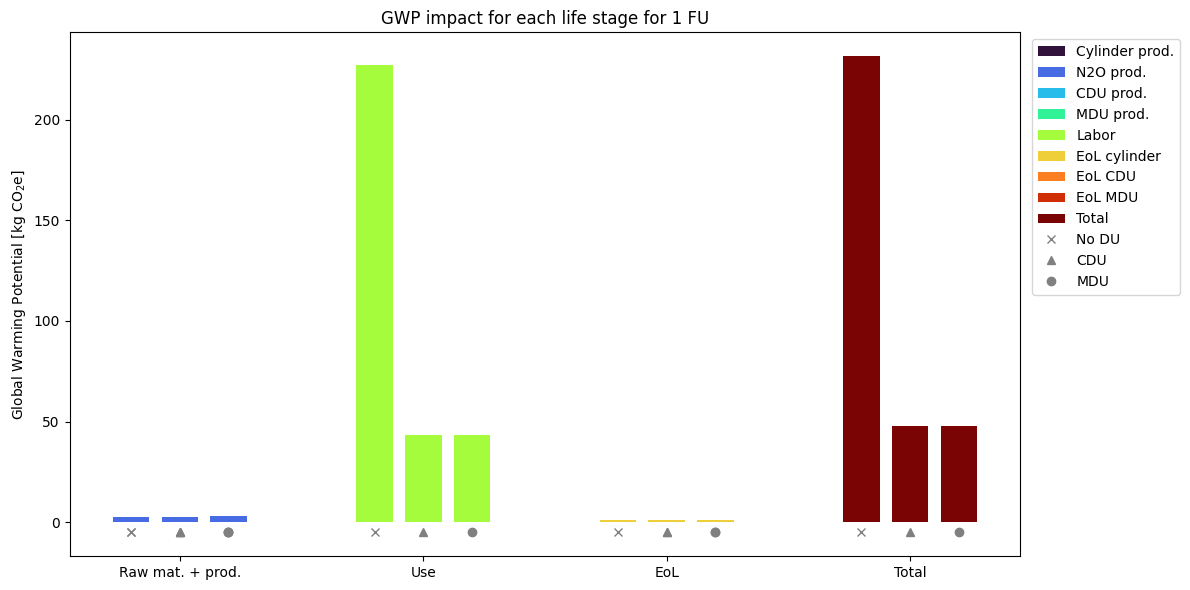

In [602]:

color_map = {}
#unique_processes = {process for sublist in x_axis for process in sublist}
for i, process in enumerate(temp):
    color_map[process] = colors[i]
    #print(process, i)



# Initialize an ordered dictionary for legend_handles to maintain the order
legend_handles = OrderedDict()

# Initialize legend_handles with keys from plot_legend and empty lists
for process in temp:
    legend_handles[process] = None

# Plotting logic
if len(x_axis) == len(GWP_value):
    num_scenarios = len(GWP_value)  # Number of scenarios
    bar_width = 0.15  # Width of the bars for each scenario
    space_between_scenarios = 0.05  # Space between each scenario set
    index = np.arange(len(categories))  # X-axis index positions for the categories

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    scenario_marker = ['x', '^', 'o']  # List of markers for scenarios
    all_markers = []  # List to store Line2D objects for markers

    # Main plotting logic
    for scenario in range(num_scenarios):
        bottom_positive = np.zeros(len(categories))  # Initialize the bottom array for positive values
        bottom_negative = np.zeros(len(categories))  # Initialize the bottom array for negative values
        scenario_index = index + scenario * (bar_width + space_between_scenarios)

        for length in range(len(x_axis[scenario])):
            process_name = x_axis[scenario][length]
            value = GWP_value[scenario][length]

            # Determine which category this process falls into
            for i, category in enumerate(categories):
                if any(keyword in process_name for keyword in category_mapping[category]):
                    # Assign color based on the process name
                    color = color_map[process_name]

                    # Create a bar with the specific color
                    if value >= 0:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_positive[i],
                                    color=color)
                        bottom_positive[i] += value
                    else:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_negative[i],
                                    color=color)
                        bottom_negative[i] += value

                    # Add the bar to the corresponding process in legend_handles
                    if legend_handles[process_name] is None:
                        legend_handles[process_name] = bar

                    # Add plot markers (symbols) at the bottom
                    ax.plot(scenario_index[i], -5, marker=scenario_marker[scenario], color='gray')

                    break

    # Add custom markers to the legend
    for i, marker in enumerate(scenario_marker):
        all_markers.append(Line2D([0], [0], marker=marker, color='gray', linestyle='None'))

    # Set x-axis labels and ticks, adjusting to account for spacing
    tick_positions = index + (num_scenarios - 1) * (bar_width + space_between_scenarios) / 2
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(categories)

    # Axis limits
    # ax.set_ylim(-.45, 3.55)
    # ax.set_yticks(np.arange(-0.5, 3.6, step=0.25))
    ax.set_ylabel("Global Warming Potential [kg CO$_2$e]")
    ax.set_title('GWP impact for each life stage for 1 FU')

    # Add markers to legend_handles for display at the bottom of the legend
    valid_legend_handles = [(k, v) for k, v in legend_handles.items() if v is not None]
    legend_handles_for_display = valid_legend_handles + [(flow_legend[i], marker) for i, marker in enumerate(all_markers)]

    if legend_handles_for_display:
        ax.legend(handles=[v for k, v in legend_handles_for_display], labels=[k for k, v in legend_handles_for_display], bbox_to_anchor=(1.005, 1), loc='upper left')

    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, f'LC_impact_ofir_APOS.jpg'), bbox_inches='tight')
    plt.show()

else:
    print('The x-axis and GWP values have different sizes')


In [603]:
eidb = bd.Database(db)

FU_new = {}
FU_uncertainties = {}
for flow in flows:
    for act in eidb:
        
        # for sc in range(1,4):
        if flow in act['name']:
            # print(act['name'])
            FU_new[flow] = {}
            FU_uncertainties[flow] = {}
            # print(act['name'])
            for exc in act.exchanges():
                # print(exc.input, exc['type'])
                if exc['type'] == 'technosphere':
                    # print(exc.input, exc.input['name'], exc['amount'], exc['type'])
                    FU_new[flow].update({exc.input : exc['amount']})
                    FU_uncertainties[flow].update({exc.input : exc.uncertainty})
                

In [604]:
def sample_lognormal(loc, scale):
    # Convert loc and scale to the parameters of the lognormal distribution
    mean = np.exp(loc)
    sigma = scale
    return np.random.lognormal(mean, sigma)


In [605]:
def data_sample(FU, uncertainties):
    sampled_data = {}

    for uncertainty_key, uncert in uncertainties.items():
        for uk, ui in uncert.items():
            if uk == 'uncertainty type' and ui == 2:  # Lognormal distribution
                sampled_data[uncertainty_key] = sample_lognormal(uncert['loc'], uncert['scale'])

    FU_copy = copy.deepcopy(FU)

    for key_copy, item_copy in FU.items():
        # print(FU_new['sc1 - No DU'][k_new])
        if key_copy in sampled_data.keys():
            updated_value = sampled_data[key_copy] * item_copy
            FU_copy[key_copy] = updated_value
            # print(k_new, sampled_data[k_new], i_new)


    return FU_copy


In [606]:
def MonteCarlo(iterations, FU, impact_category, uncertainties):
    # Initialize an array to store the LCIA results for each iteration
    lcia_results_array = np.zeros(iterations)

    # Perform Monte Carlo simulation
    for i in range(iterations):

        
        FU_updated = data_sample(FU, uncertainties)

        # Use the sampled data in the Monte Carlo LCA
        MC_lca = bw.MonteCarloLCA(FU_updated, impact_category)
        MC_lca.lci()
        
        # Initialize cf_params if not already set
        if not hasattr(MC_lca, 'cf_params'):
            MC_lca.cf_params = MC_lca.load_lcia_data()

        # Rebuild the characterization matrix if it's not already initialized
        if not hasattr(MC_lca, 'characterization_matrix'):
            MC_lca.rebuild_characterization_matrix(MC_lca.method)

        # Perform LCIA calculation directly
        MC_lca.lcia_calculation()
        
        # Store the LCIA result in the array
        lcia_results_array[i] = MC_lca.score
        print(f'Iteration {i+1} of {iterations}')
    
    return lcia_results_array

In [607]:
sampled_data = {}
params = FU_uncertainties['sc1 - No DU']
for i, uncert in params.items():
    for uk, ui in uncert.items():
        if uk == 'uncertainty type' and ui == 2:  # Lognormal distribution
            sampled_data[i] = sample_lognormal(uncert['loc'], uncert['scale'])

FU_new_copy = copy.deepcopy(FU_new)
for k_new, i_new in FU_new['sc1 - No DU'].items():
    # print(FU_new['sc1 - No DU'][k_new])
    if k_new in sampled_data.keys():
        updated_value = sampled_data[k_new] * i_new
        FU_new_copy['sc1 - No DU'][k_new] = updated_value
FU_new_copy['sc1 - No DU']

{'Steel cylinder' (unit, GLO, None): 7.503986816609326e-06,
 'nitrous oxide production' (kilogram, RER, None): 0.867460675121784,
 'Use phase basecase' (unit, GLO, None): 2.478249179915839,
 'EoL 50L cylinder - FU' (unit, GLO, None): 4.957642394139524e-06}

In [ ]:
# Number of iterations for Monte Carlo simulation
iterations = 25
Monte_Carlo_dct = {}
MC_idx = ['Mean', 'Median', 'Standard Deviation', 'Minimum', 'Maximum']

# Define the LCIA method
method = impact_category[1]
# for method in impact_category:
print(f'Doing Monte Carlo simulations for {method[1]}')

# Create a DataFrame to store results
df_MC = pd.DataFrame(0, index=MC_idx, columns=FU_new.keys(), dtype=object)  # dtype=object to handle lists
raw_data = []
for col in df_MC.columns:
    print(f'Processing {col}')
    lcia_results_array = MonteCarlo(iterations, FU_new[col], method, FU_uncertainties[col])
    raw_data.append(lcia_results_array)
    for index, row in df_MC.iterrows():
        # print(index, row[col])
        if 'mean' in index.lower():
            row[col] = np.mean(lcia_results_array)
            # print(index)
        elif 'median' in index.lower():
            row[col] = np.median(lcia_results_array)
            # print(index)
        elif 'standard' in index.lower():
            row[col] = np.std(lcia_results_array)
            # print(index)
        elif 'minimum' in index.lower():
            row[col] = np.min(lcia_results_array)
            # print(index)
        elif 'maximum' in index.lower():
            row[col] = np.max(lcia_results_array)
            # print(index)
        
        
            
# Monte_Carlo_dct[method[1]] = df_MC

In [608]:
df_MC
# print(f'Monte Carlo simulations for {iterations} iterations for the different impact categories:')
# for i, dataframe in enumerate(Monte_Carlo_dct.values()):
#     print(impact_category[i][1])

#     print(dataframe)
#     print()

,sc1 - No DU,sc2 - CDU,sc3 - MDU
Mean,579.122694,122.328624,129.135722
Median,572.832989,121.921869,131.97716
Standard Deviation,109.769096,25.580691,26.664932
Minimum,410.469272,85.9112,71.50489
Maximum,816.409024,191.524626,190.460338


In [609]:
data = raw_data[0].tolist()

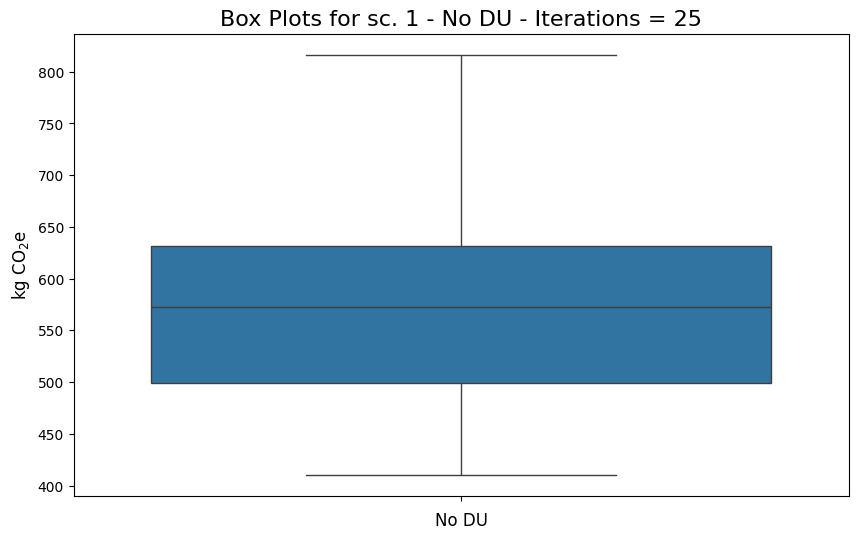

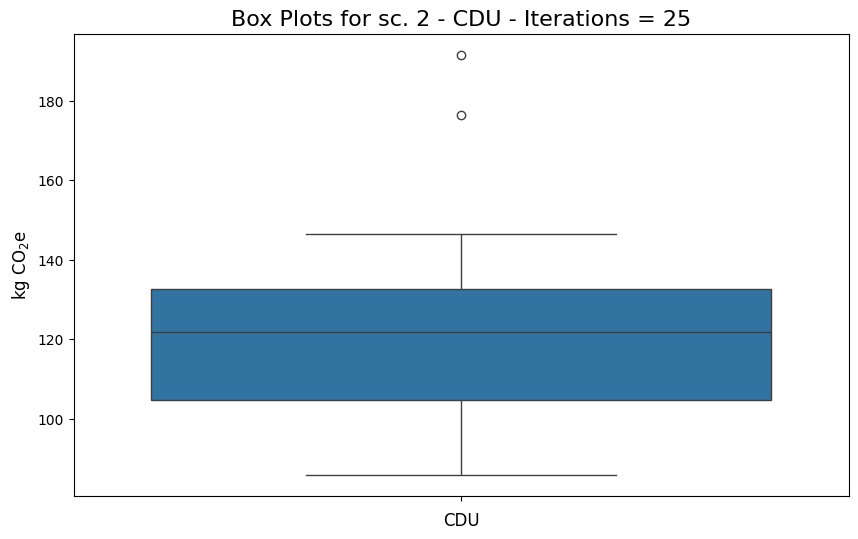

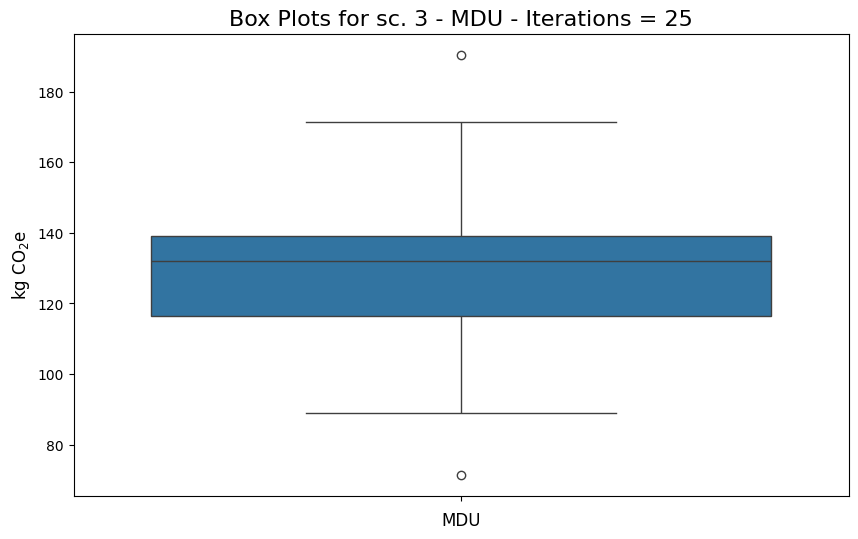

In [613]:

for scenario, data in enumerate(raw_data):
    data = data.tolist()
    # Create box plot for each scenario (column)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)

    # Set plot labels and title
    plt.title(f'Box Plots for sc. {scenario+1} - {flow_legend[scenario]} - Iterations = {iterations}', size=16)
    plt.xlabel(flow_legend[scenario], size=12)
    plt.ylabel('kg CO$_2$e', size=12)

    # Show the plot
    plt.show()

In [612]:
# Create a function to clean the sheet names
def clean_sheet_name(sheet_name, max_length=31):
    # Replace invalid characters with an underscore
    cleaned_name = re.sub(r'[\\/:*?\'<>\[\]]', ' -', sheet_name)
    # Truncate the name to the max allowable length (31 characters)
    return cleaned_name[:max_length]

In [ ]:
file_MC = 'monte_carlo_simulations_Rune.xlsx'
# Create an Excel writer object
with pd.ExcelWriter(file_MC, engine='xlsxwriter') as writer:
    for i, dataframe in enumerate(Monte_Carlo_dct.values()):
        # Get the sheet name and clean it
        sheet_name = clean_sheet_name(impact_category[i][1])
        # Save the dataframe to the corresponding sheet
        dataframe.to_excel(writer, sheet_name=sheet_name)